In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
X = train.drop(columns=['SalePrice'], axis=1)
y = train['SalePrice']

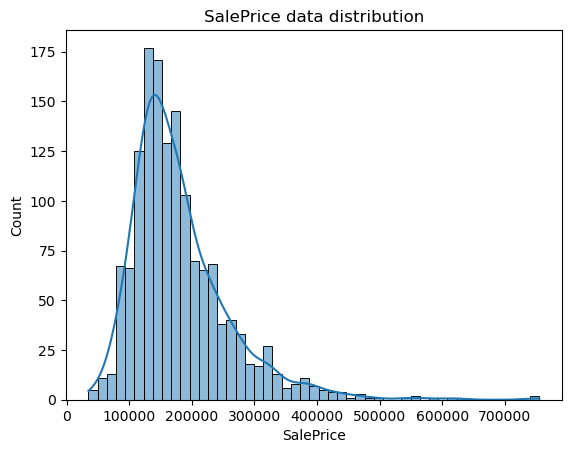

In [6]:
sns.histplot(x=y, kde=True)
plt.title('SalePrice data distribution')
plt.show()

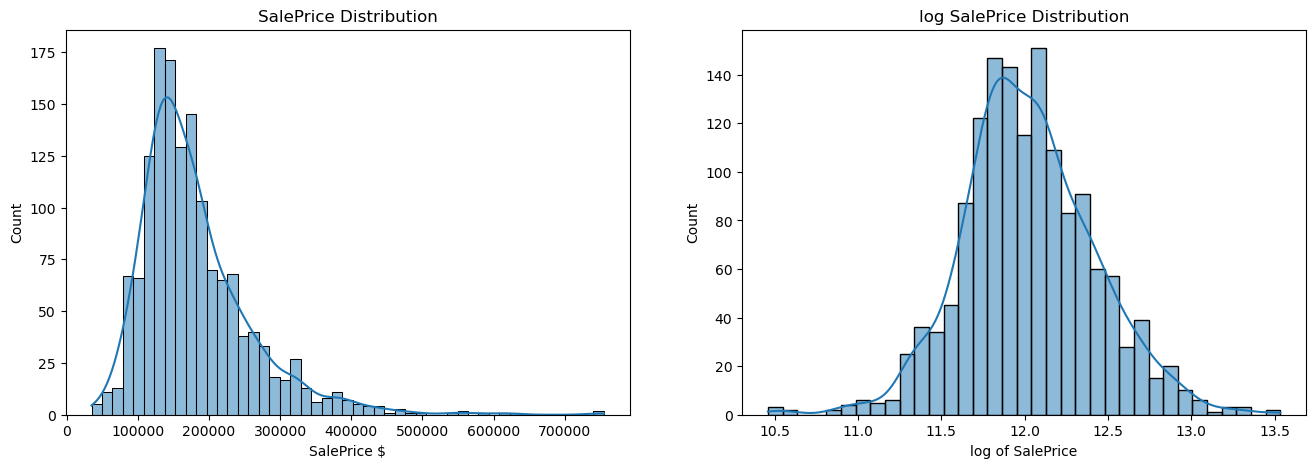

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
sns.histplot(x=y, kde=True, ax=ax[0])
sns.histplot(x=np.log1p(y), kde=True, ax=ax[1])
ax[0].set(title='SalePrice Distribution', xlabel='SalePrice $')
ax[1].set(title='log SalePrice Distribution', xlabel='log of SalePrice')
plt.show()

In [8]:
y = np.log1p(y)

## Preprocessing

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [15]:
def get_preprocessor(X):
    
    # Numeric column transformers
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    )

    # Categorical column transformer
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(handle_unknown='ignore')
    )
    
    # Separate columns as dtype
    numeric_column = X.select_dtypes(exclude=['object']).columns
    categorical_column = X.select_dtypes(include=['object']).columns

    # Preprocessor main transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_column),
            ('cat', categorical_transformer, categorical_column)
        ]
    )
    
    return preprocessor

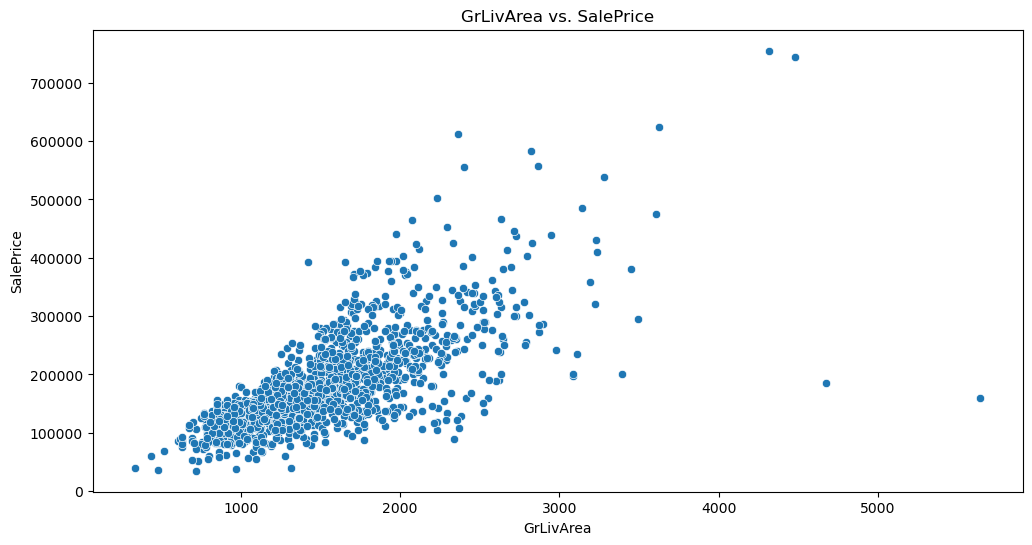

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for GrLivArea vs. SalePrice
plt.figure(figsize=(12, 6))
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'])
plt.title('GrLivArea vs. SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()


In [30]:
preprocessor = get_preprocessor(train)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF',...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])

In [33]:
data_preprocessed = preprocessor.fit_transform(train)

In [34]:
data_preprocessed

<1460x290 sparse matrix of type '<class 'numpy.float64'>'
	with 118260 stored elements in Compressed Sparse Row format>

In [55]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=4, contamination=0.02)

# Fit and predict outliers
outliers = lof.fit_predict(data_preprocessed)


In [56]:
outliers


array([1, 1, 1, ..., 1, 1, 1])

In [57]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  30, 1430]))

In [58]:
train_1 = train
train_1

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [59]:
data_clean = train_1[outliers == 1]
data_clean

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


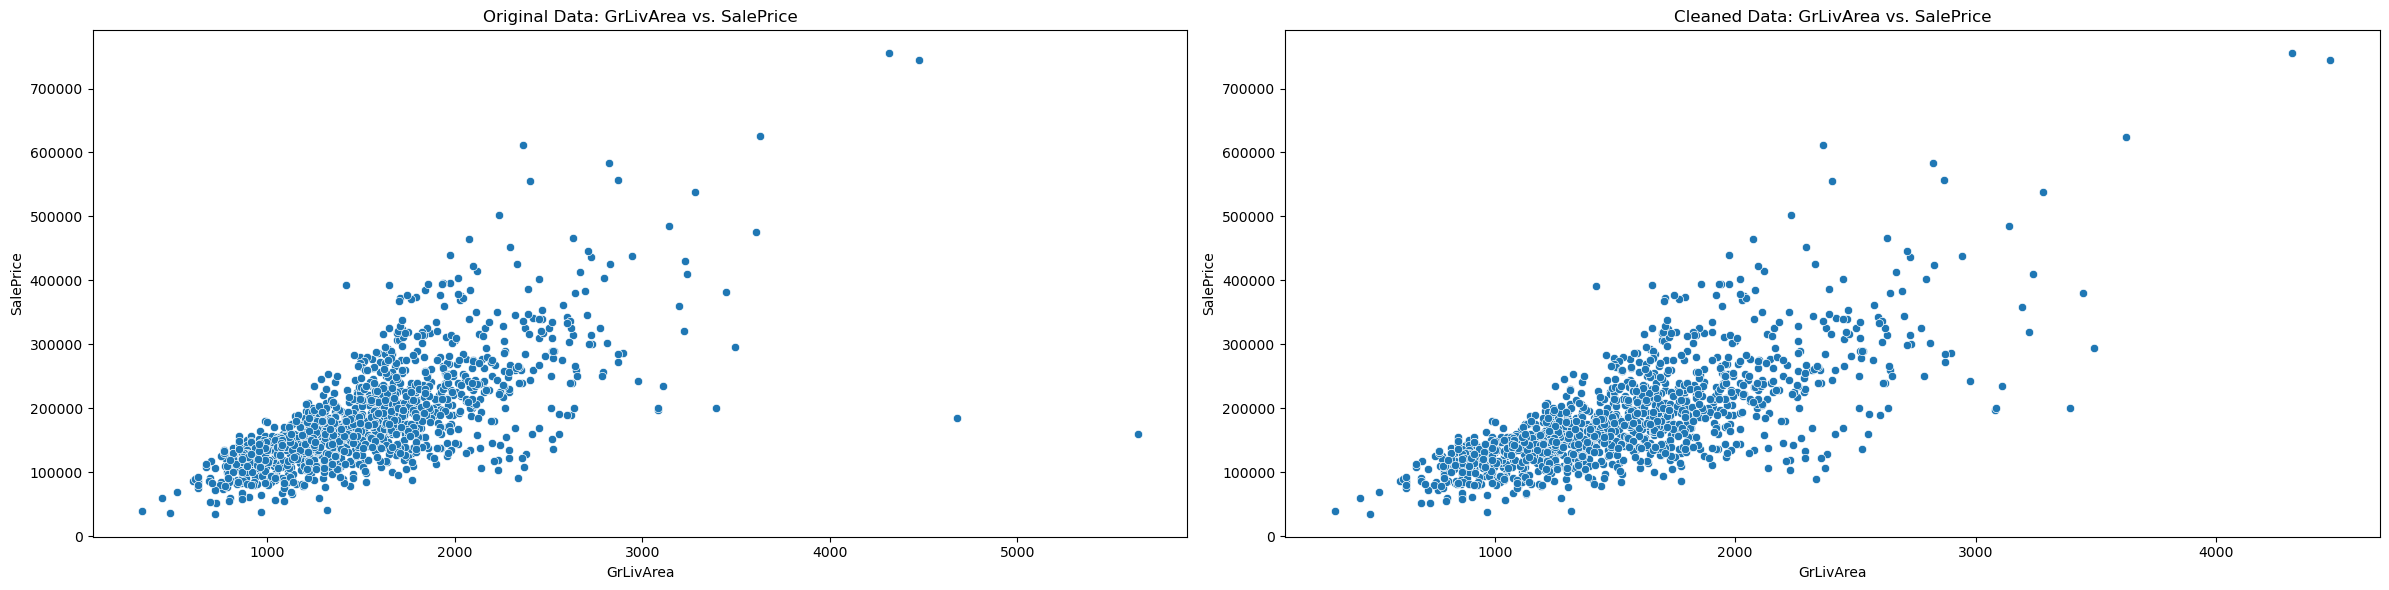

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Original Data
sns.scatterplot(ax=axes[0], x=train['GrLivArea'], y=train['SalePrice'])
axes[0].set_title('Original Data: GrLivArea vs. SalePrice')
axes[0].set_xlabel('GrLivArea')
axes[0].set_ylabel('SalePrice')

# Cleaned Data
sns.scatterplot(ax=axes[1], x=data_clean['GrLivArea'], y=data_clean['SalePrice'])
axes[1].set_title('Cleaned Data: GrLivArea vs. SalePrice')
axes[1].set_xlabel('GrLivArea')
axes[1].set_ylabel('SalePrice')

# Show plots
plt.tight_layout()
plt.show()
